In [107]:
#!ls track

In [108]:
#!pip3 install imgaug

In [109]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random

In [110]:
keras.backend.clear_session()

In [111]:
datadir = 'track'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_19_07_22_19_50_32_056218.jpg,center_19_07_22_19_50_32_056218.jpg,center_19_07_22_19_50_32_056218.jpg,0,0.0,NaN,100.0
1,center_19_07_22_19_50_32_151105.jpg,center_19_07_22_19_50_32_151105.jpg,center_19_07_22_19_50_32_151105.jpg,0,0.0,NaN,100.0
2,center_19_07_22_19_50_32_241414.jpg,center_19_07_22_19_50_32_241414.jpg,center_19_07_22_19_50_32_241414.jpg,0,0.0,NaN,100.0
3,center_19_07_22_19_50_32_333987.jpg,center_19_07_22_19_50_32_333987.jpg,center_19_07_22_19_50_32_333987.jpg,0,0.0,NaN,100.0
4,center_19_07_22_19_50_32_426629.jpg,center_19_07_22_19_50_32_426629.jpg,center_19_07_22_19_50_32_426629.jpg,0,0.0,NaN,100.0


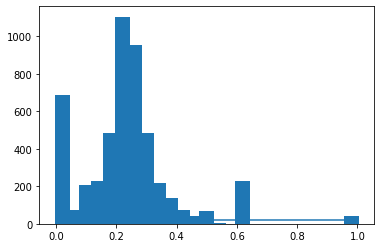

In [112]:
num_bins = 25
samples_per_bin = 20
steering = data['steering']
normalized_X = minmax_scale(steering)
hist, bins = np.histogram(normalized_X, num_bins)

center = (bins[: -1] + bins[1:]) * 0.5
plt.bar(center, hist, width = 0.05)
plt.plot((np.min(normalized_X), np.max(normalized_X)), (samples_per_bin, samples_per_bin))

total data: 5034
removed: 16700
remaining: 4346


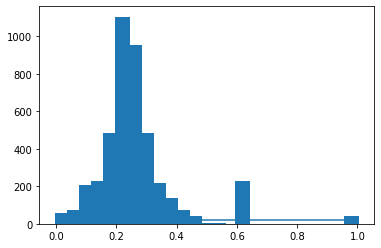

In [113]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
    list_ = []
    for i in range(len(data['speed'])):
        if data['speed'][i] == 100:
            list_.append(i)
    list_ = shuffle(list_)
    list_ = list_[samples_per_bin:]
    remove_list.extend(list_)

print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

steering = data['steering']
normalized_X = minmax_scale(steering)

hist, _ = np.histogram(normalized_X, (num_bins))
plt.bar(center, hist, width = 0.05)
plt.plot((np.min(normalized_X), np.max(normalized_X)), (samples_per_bin, samples_per_bin))

In [114]:
print(data.iloc[1])
def load_img_steering(datadir, df):
    image_path = []
    steering = []
    for i in range(len(data)):
        indexed_data = data.iloc[i]
        center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
        image_path.append(os.path.join(datadir, center.strip()))
        steering.append(float(indexed_data[3]))
    image_paths = np.array(image_path)
    steerings = np.array(steering)
    return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)

center      center_19_07_22_19_50_36_596997.jpg
left        center_19_07_22_19_50_36_596997.jpg
right       center_19_07_22_19_50_36_596997.jpg
steering    45                                 
throttle    0.0100542                          
reverse     forward                            
speed       100.402                            
Name: 49, dtype: object


In [115]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 3476
Valid Samples: 870


Text(0.5, 1.0, 'Validation set')

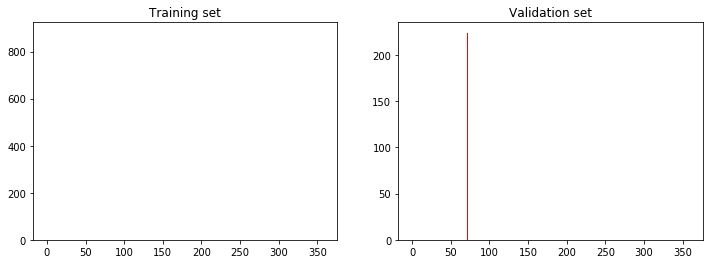

In [116]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [117]:
def zoom(image):
    zoom = iaa.Affine(scale=(1,1.3))
    image = zoom.augment_image(image)
    return image

Text(0.5, 1.0, 'Zoomed Image')

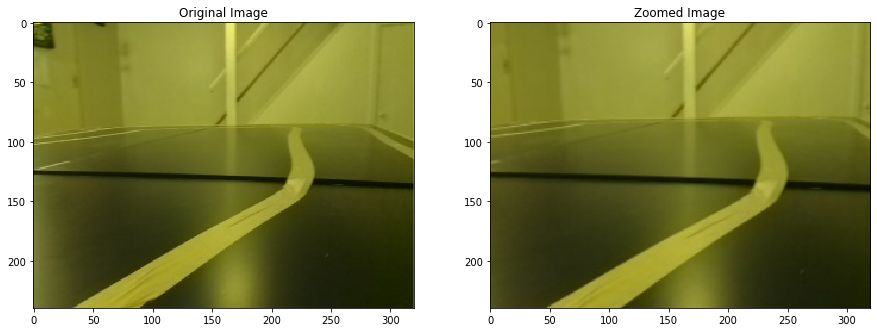

In [118]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout=()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

In [119]:
def pan(image):
    pan = iaa.Affine(translate_percent={'x': (-0.1, 0.1), 'y': (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image

Text(0.5, 1.0, 'Panned Image')

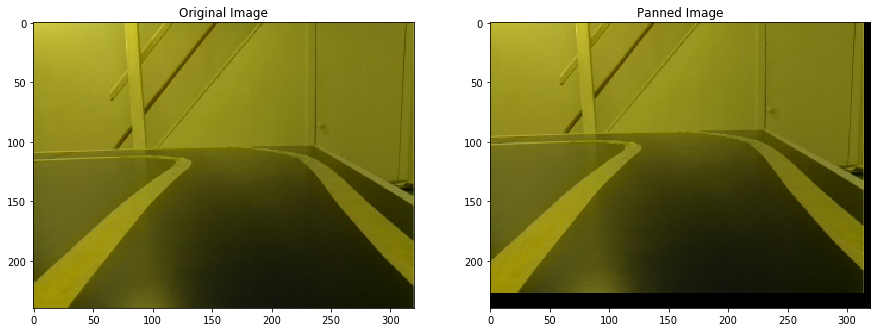

In [120]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout=()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

In [121]:
def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image

Text(0.5, 1.0, 'Brightness Altered Image')

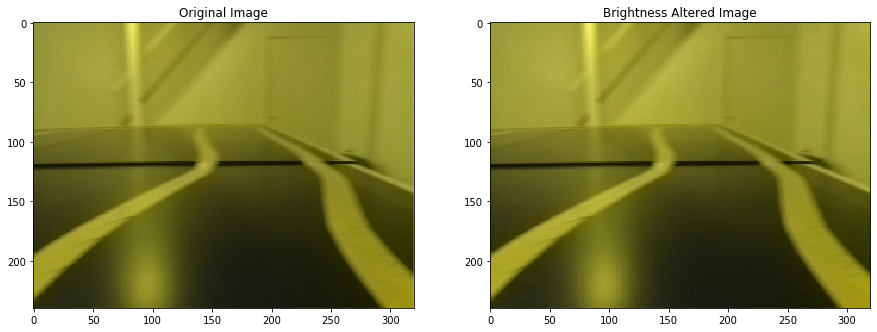

In [122]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout=()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness Altered Image')

In [123]:
def img_random_flip(image, steering_angle):
    image = cv2.flip(image, 1)
    steering_angle = -steering_angle
    return image, steering_angle

Text(0.5, 1.0, 'Flipped ImageSteering Angle:-83.0')

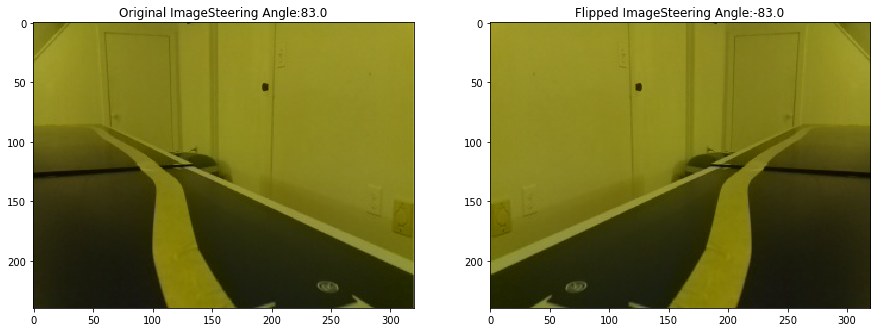

In [124]:
random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]
original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout=()

axs[0].imshow(original_image)
axs[0].set_title('Original Image' + 'Steering Angle:' + str(steering_angle))

axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image' + 'Steering Angle:' + str(flipped_steering_angle))

In [125]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = img_random_brightness(image)
    if np.random.rand() < 0.5:
        image, steering_angle = img_random_flip(image, steering_angle)
    return image, steering_angle

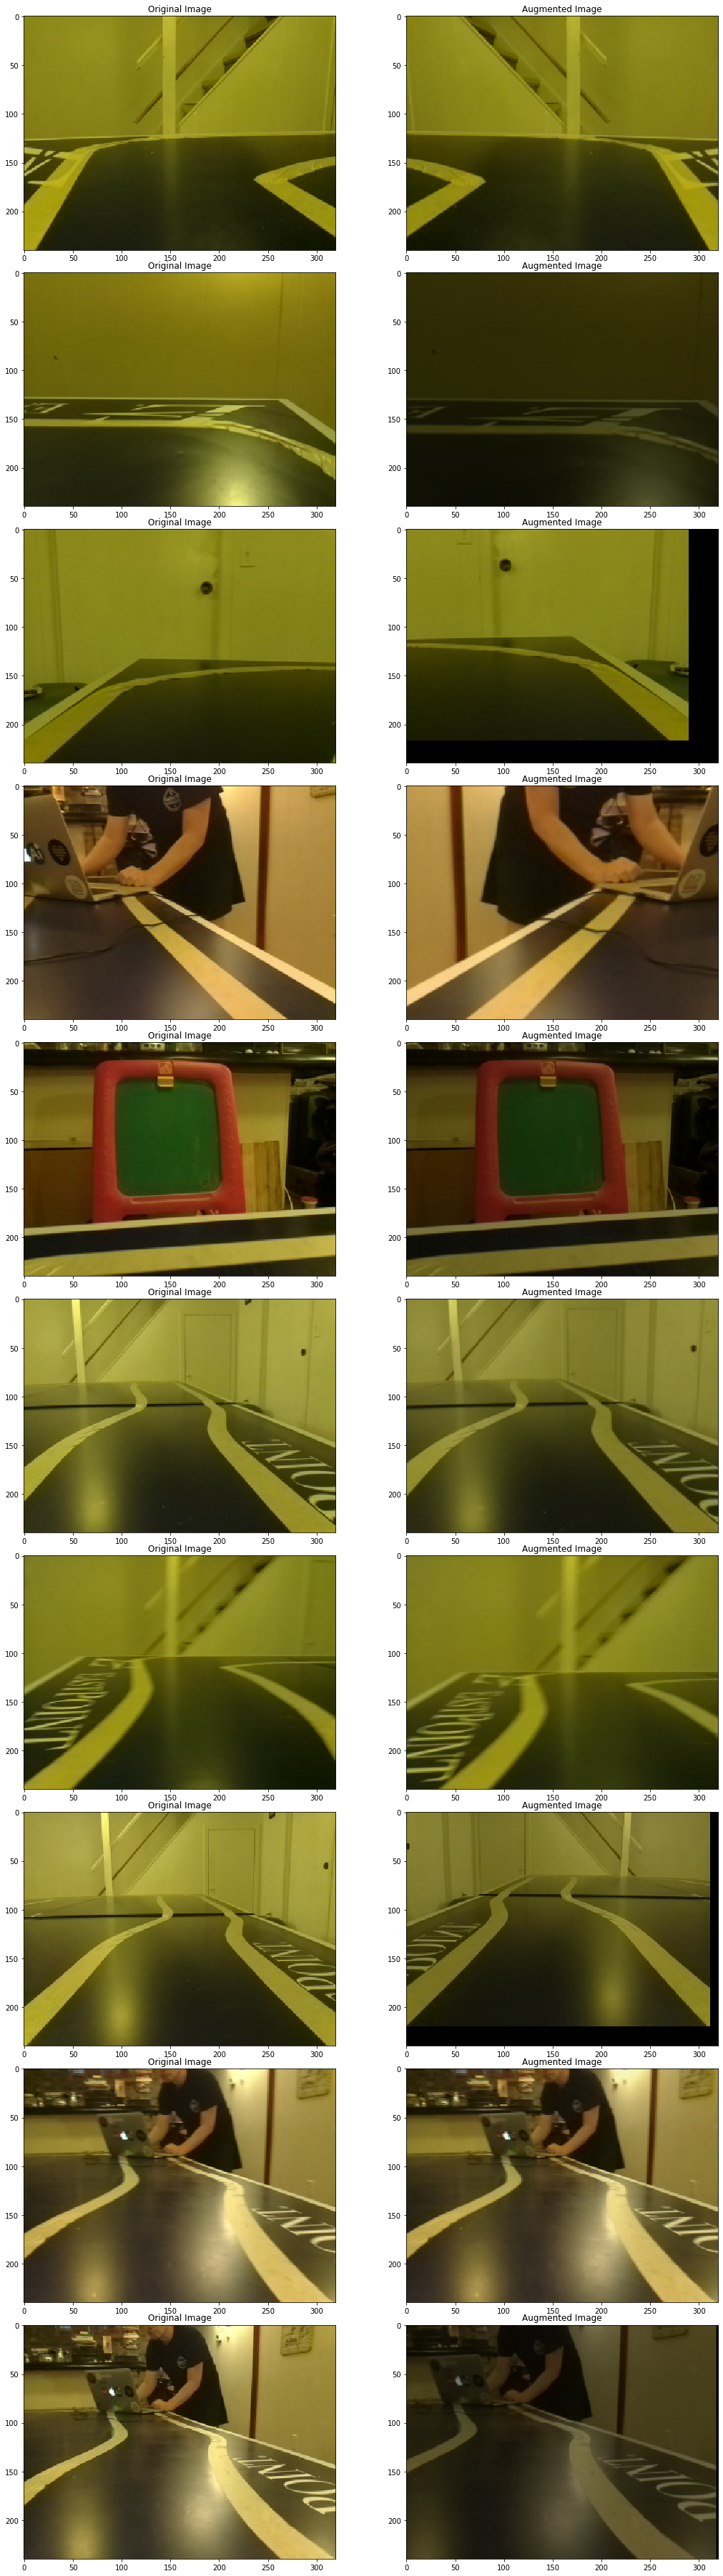

In [126]:
ncol = 2
nrow = 10
fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()

for i in range(10):
    randnum = random.randint(0, len(image_paths) - 1)
    random_image = image_paths[randnum]
    random_steering = steerings[randnum]
    
    original_image = mpimg.imread(random_image)
    augmented_image, steering = random_augment(random_image, random_steering)
    
    axs[i][0].imshow(original_image)
    axs[i][0].set_title('Original Image')
    
    axs[i][1].imshow(augmented_image)
    axs[i][1].set_title('Augmented Image')
    

In [127]:
def img_preprocess(img):
    img = img[100:300, :,: ]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV) # for nvidia neural model 
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.resize(img, (200,66)) # size for nvidia model
    img = img / 255 # normalization 
    return img

Text(0.5, 1.0, 'Preprocessed Image')

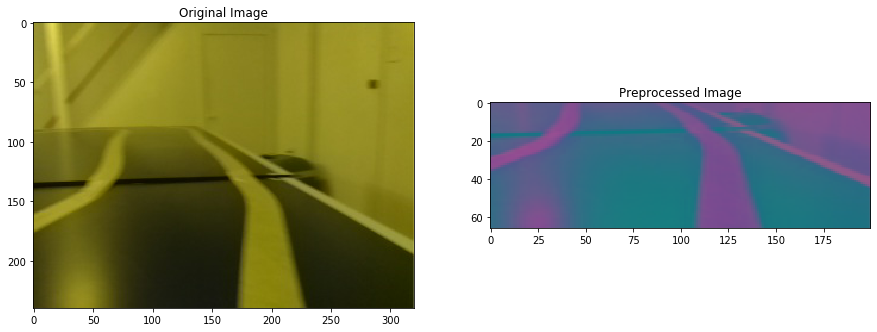

In [128]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout=()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [129]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
    while True:
        batch_img = []
        batch_steering = []
        
        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths) - 1)
            if istraining:
                im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
            else:
                im = mpimg.imread(image_paths[random_index])
                steering = steering_ang[random_index]
            
            im = img_preprocess(im)
            batch_img.append(im)
            batch_steering.append(steering)
            
        yield (np.asarray(batch_img), np.asarray(batch_steering))

Text(0.5, 1.0, 'Validation Image')

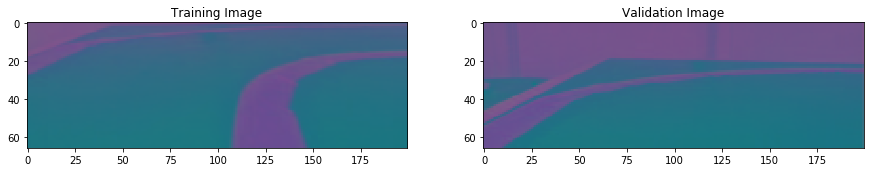

In [130]:
X_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
X_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout=()
axs[0].imshow(X_train_gen[0])
axs[0].set_title('Training Image')
axs[1].imshow(X_valid_gen[0])
axs[1].set_title('Validation Image')

In [131]:
# X_train = np.array(list(map(img_preprocess, X_train)))
# X_valid = np.array(list(map(img_preprocess, X_valid)))

In [132]:
# plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
# plt.axis('off')
# print(X_train.shape)

In [144]:
def nvidia_model():
    model = Sequential()
    model.add(Conv2D(24, (5, 5), subsample=(2, 2), input_shape=(66, 200, 3), activation='elu'))
    model.add(Conv2D(36, (5, 5), subsample=(2, 2), activation='elu'))
    model.add(Conv2D(48, (5, 5), subsample=(2, 2), activation='elu'))
    model.add(Conv2D(64, (3, 3), activation='elu'))
    model.add(Conv2D(64, (3, 3), activation='elu'))
#     model.add(Dropout(0.5))
    
    model.add(Flatten()) #1152 pixel
    model.add(Dense(100, activation='elu'))
#     model.add(Dropout(0.5))
    
    model.add(Dense(50, activation='elu'))
#     model.add(Dropout(0.5))
    
    model.add(Dense(10, activation='elu'))
#     model.add(Dropout(0.5))
    
    model.add(Dense(1)) # steering angle
    
    optimizer = Adam(lr=1e-4)
    model.compile(loss='mse', optimizer=optimizer)
    return model
    

In [145]:
model = nvidia_model()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_3 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 100)               115300    
__________

/home/san/anaconda3/envs/myenviron/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="elu", strides=(2, 2))`
  This is separate from the ipykernel package so we can avoid doing imports until
/home/san/anaconda3/envs/myenviron/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  after removing the cwd from sys.path.
/home/san/anaconda3/envs/myenviron/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  """
/home/san/anaconda3/envs/myenviron/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  
/home/san/anaconda3/envs/myenviron/lib/python3.6/s

In [146]:
# history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), batch_size=100, verbose=1, shuffle=1)
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1), 
                              steps_per_epoch=300, 
                              epochs=10, 
                              validation_data=batch_generator(X_valid, y_valid, 100, 0), 
                              validation_steps=200,
                              verbose=1, 
                              shuffle=1)

Epoch 1/10
300/300 [==============================] - 137s 458ms/step - loss: 9836.6789 - val_loss: 7299.1198
Epoch 2/10
300/300 [==============================] - 136s 455ms/step - loss: 7115.5591 - val_loss: 5895.2889
Epoch 3/10
300/300 [==============================] - 138s 460ms/step - loss: 6184.4032 - val_loss: 6249.2095
Epoch 4/10
300/300 [==============================] - 139s 462ms/step - loss: 5431.5792 - val_loss: 5634.1870
Epoch 5/10
300/300 [==============================] - 140s 467ms/step - loss: 4814.2010 - val_loss: 4925.9974
Epoch 6/10
300/300 [==============================] - 142s 473ms/step - loss: 4538.6905 - val_loss: 4557.9193
Epoch 7/10
300/300 [==============================] - 136s 453ms/step - loss: 4113.5617 - val_loss: 3987.4558
Epoch 8/10
300/300 [==============================] - 139s 462ms/step - loss: 3894.7895 - val_loss: 4115.6780
Epoch 9/10
300/300 [==============================] - 142s 472ms/step - loss: 3648.4961 - val_loss: 3944.9655
Epoch 10/1

Text(0.5, 0, 'Epoch')

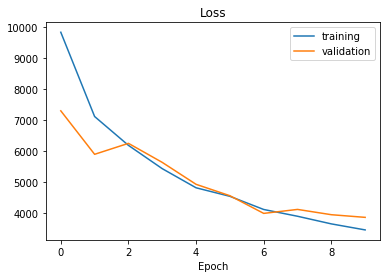

In [147]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [148]:
model.save('model2.h5')